# Licences / Notes

In [54]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [55]:
#Adapted by Thierry Lincoln in November,2019 from this Colab notebook:
#https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb.
#Changes includes 

# - Reading our stressor data and parsing it properly
# - reconfiguring the last layer to include N neurons corresponding to N categories
# - correcting the probability output so that it follows [0,1] proper pattern 
# - better analysis with confusion matrix
# - exporting to pb format for tensorflow serving api

Intro:

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

# Loading Libraries

In [56]:
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #(or "1" or "2")

In [57]:
import sys
print(sys.executable)

/commuter/thierrylincoln/Tf1.1_py36/bin/python3.6


In [58]:
#export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib
#export CUDA_VISIBLE_DEVICES=0

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score

import logging
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [60]:
print(tf.__version__) #needs to be version 1.15.0, version 2.0 doesn't work with this notebook

1.15.0


In [61]:

config = tf.ConfigProto()
#config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
#config.gpu_options.visible_device_list="0"



from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18085235191764673450, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1428132625281340425
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1833332232812009565
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11938077082
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11822145187220765268
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1"]

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [62]:
#!pip install bert-tensorflow

In [63]:
import bert
from bert import run_classifier_with_tfhub
from bert import optimization
from bert import tokenization
from bert import modeling 
import numpy as np


Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. 


Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

## Utils functions 

In [234]:
def create_examples_prediction(df):
    """Creates examples for the training and dev sets."""
    examples = []
    for index, row in df.iterrows():
        
        labels = row[LABEL_HOT_VECTOR].strip('][').split(', ')
        labels = [float(x) for x in labels]
        examples.append(labels)
        
    return pd.DataFrame(examples)

In [140]:
def f(x):
    n = 2  # index of the second proability to get labeled 

    index = np.argsort(x.values.flatten().tolist())[-n:][0]
    print(f"index is {index}")
    label  = label_list_text[index]
    print(f"label is {label}")
    
    return label
    

In [235]:
def get_test_experiment_df(test):
    test_predictions = [x[0]['probabilities'] for x in zip(getListPrediction(in_sentences=list(test[DATA_COLUMN])))]
    test_live_labels = np.array(test_predictions).argmax(axis=1)
    test['Predicted label'] = [label_list_text[x] for x in test_live_labels] # appending the labels to the dataframe
    
    probabilities_df_live = pd.DataFrame(test_predictions) # creating a proabilities dataset
    probabilities_df_live.columns = [x + " Predicted"for x in label_list_text] # naming the columns
    probabilities_df_live['Predicted label 2'] = probabilities_df_live.apply(lambda x:f(x),axis=1)
    
    print(test)
    label_df = create_examples_prediction(test)
    label_df.columns = label_list_text
    label_df['label 2'] = label_df.apply(lambda x:f(x),axis=1)

    test.reset_index(inplace=True,drop=True) # resetting index 

    experiment_df = pd.concat([test,probabilities_df_live,label_df],axis=1, ignore_index=False)
    experiment_df = experiment_df.reindex(sorted(experiment_df.columns), axis=1)
    return test,experiment_df

In [142]:
def getListPrediction(in_sentences):
    #1
    input_examples = [InputExample(guid="", text_a = x, text_b = None, labels = [0]*len(label_list)) for x in in_sentences] # here, "" is just a dummy label
    
    #2
    input_features = convert_examples_to_features(input_examples, MAX_SEQ_LENGTH, tokenizer)
    
    #3
    predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    
    print(input_features[0].input_ids)
    #4
    predictions = estimator.predict(input_fn=predict_input_fn,yield_single_examples=True)
    
    return predictions

In [143]:
is_normalize_active=False

def get_confusion_matrix(y_test,predicted,labels):
    class_names=labels
    # plotting confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names,
                        title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        test =1
        #print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


# Loading the data

In [144]:
def data_prep_bert(df,test_size):
    
    #print("Filling missing values")
    #df[DATA_COLUMN] = df[DATA_COLUMN].fillna('_NA_')
    
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=test_size, random_state=2018,stratify = df[LABEL_COLUMN_RAW])

    return X_train, X_test


In [220]:
def open_dataset(NAME,mapping_index,excluded_categories):
    df = pd.read_csv(PATH+NAME+'.csv',sep =',')
    
    df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].fillna("Other")

    
    
    #df.columns = [LABEL_COLUMN_RAW,'Severity',DATA_COLUMN,'Source']
    
    if excluded_categories is not None:
        for category in excluded_categories:

            df = df[df[LABEL_COLUMN_RAW] !=category]

    label_list=[]
    label_list_final =[]
    if(mapping_index is None):
        df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].astype('category')
        df[LABEL_COLUMN], mapping_index = pd.Series(df[LABEL_COLUMN_RAW]).factorize() #uses pandas factorize() to convert to numerical index
        
        
        
        
    else:
        df[LABEL_COLUMN] = df[LABEL_COLUMN_RAW].apply(lambda x: mapping_index.get_loc(x))
    
    label_list_final = [None] * len(mapping_index.categories)
    label_list_number = [None] * len(mapping_index.categories)

    for index,ele in enumerate(list(mapping_index.categories)):
        lindex = mapping_index.get_loc(ele)
        label_list_number[lindex] = lindex
        label_list_final[lindex] = ele
    
    frequency_dict = df[LABEL_COLUMN_RAW].value_counts().to_dict()
    df["class_freq"] = df[LABEL_COLUMN_RAW].apply(lambda x: frequency_dict[x])
    
    
    return df,mapping_index,label_list_number,label_list_final
    

# Require user changes > Start Here 

### Experiment Name

In [215]:
PATH = './datasets/'
TODAY_DATE = "27_04_2020/"
EXPERIMENT_NAME = 'main_turk_analysis_of_5_turkers_popbots_test_live'
EXPERIMENTS_PATH = PATH + 'experiments/'+TODAY_DATE+EXPERIMENT_NAME
if not os.path.exists(PATH + 'experiments/'+TODAY_DATE):
    os.mkdir(PATH + 'experiments/'+TODAY_DATE)
if not os.path.exists(EXPERIMENTS_PATH):
    os.mkdir(EXPERIMENTS_PATH)

### Model Hyperparameters

In [216]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 100

# We'll set sequences to be at most 32 tokens long.
MAX_SEQ_LENGTH = 32


OUTPUT_DIR = './models/'+EXPERIMENT_NAME+ '/' #_01_04_2020/

##use downloaded model, change path accordingly
BERT_VOCAB= './bert_model/uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = './bert_model/uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = './bert_model/uncased_L-12_H-768_A-12/bert_config.json'


In [219]:
DATASET_NAME = 'main_turk_analysis_of_5_turkers'

DATA_COLUMN = 'Input.text'
LABEL_COLUMN_RAW = 'labels'#'Answer.Label'
LABEL_COLUMN = 'label_numeric'

MTURK_NAME = 'mTurk_synthetic'
LIVE_NAME = 'popbots_live'

LABEL_HOT_VECTOR = 'label_conf'

#dataset,mapping_index,label_list, label_list_text = open_dataset('mturk900balanced',None)

EXCLUDED_CATEGORIES = None #['Other'] #None # # if nothing to exclude put None, THIS ALWAYS MUST BE A LIST 
mapping_dict = {'Other': 0, 'Everyday Decision Making': 1, 'Work': 2, 'Social Relationships': 3, 'Financial Problem': 4, 'Emotional Turmoil': 5, 'Health, Fatigue, or Physical Pain': 6, 'School': 7, 'Family Issues': 8}
mapping_index = pd.CategoricalIndex([key for key,value in mapping_dict.items()])
dataset,mapping_index,label_list, label_list_text = open_dataset(DATASET_NAME,mapping_index,EXCLUDED_CATEGORIES)

#dataset = dataset[dataset['is_stressor'] == 1]

test_on_mturk_and_popbots_live = False # include live data in training + include mturk in testing


if test_on_mturk_and_popbots_live:
    
    mturk = dataset[dataset['Source']== MTURK_NAME]
    live = dataset[dataset['Source']== LIVE_NAME]
    live = live.sample(frac=1).reset_index(drop=True) # shuffle live
    
    TEST_PERCENTAGE = len(live)/(2*len(mturk))  # given to set the percentage of mturk used as test set to have 50/50
    
    print(f"Test percentage is {TEST_PERCENTAGE}")

    train,test = data_prep_bert(mturk,TEST_PERCENTAGE) # test size from mturk 
    
    train = train.append(live.loc[0:int(len(live)/2)]) # taking 1/2 of that dataset for training
    
    test = test.append(live.loc[int(len(live)/2):int(len(live))]) # taking 1/2 of live dataset for testing
else:
    # or taking live only for testing
    train,test = dataset[dataset['Source']== MTURK_NAME],dataset[dataset['Source']== LIVE_NAME] 

train = train[train['is_stressor'] == 1] # remove only non stressor from train

#print(f"Dataset has {len(dataset)} training examples")
print(f"Normal label list is {label_list}")
print(f"The labels text is {label_list_text}")

#Export train test to csv
#train.to_csv(PATH+'900_CSV_SPLITTED/train.csv')
#test.to_csv(PATH+'900_CSV_SPLITTED/test.csv')

185
185
Normal label list is [0, 1, 2, 3, 4, 5, 6, 7, 8]
The labels text is ['Other', 'Everyday Decision Making', 'Work', 'Social Relationships', 'Financial Problem', 'Emotional Turmoil', 'Health, Fatigue, or Physical Pain', 'School', 'Family Issues']


### Train set and test set analysis

In [212]:
def print_dataset_info(train,test):
    print(f"Train size {len(train)} with {len(train[train['Source']== LIVE_NAME])} from Popbots and {len(train[train['Source']== MTURK_NAME])} from mturk")
    print(f"Test size {len(test)} with {len(test[test['Source']== LIVE_NAME])} from Popbots and {len(test[test['Source']== MTURK_NAME])} from mturk")
    
    print('\nTraining distribution:')
    print(pd.pivot_table(train[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)
          
    print('\nTesting distribution:')
    print(pd.pivot_table(test[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)

In [213]:
len(test)

162

In [202]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything
test = test.sample(frac=1).reset_index(drop=True)

In [203]:
print('\nAll dataset distribution:')
print(pd.pivot_table(dataset[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=T


All dataset distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     87
                                   popbots_live         8
Everyday Decision Making           mTurk_synthetic    121
                                   popbots_live        24
Family Issues                      mTurk_synthetic    232
                                   popbots_live        11
Financial Problem                  mTurk_synthetic    356
                                   popbots_live         4
Health, Fatigue, or Physical Pain  mTurk_synthetic    120
                                   popbots_live        23
Other                              Other               48
                                   mTurk_synthetic    118
                                   popbots_live        18
School                             mTurk_synthetic    153
                                   popbots_live        14
Social Relationships               mTurk_synthetic  

In [204]:
print_dataset_info(train,test)

Train size 1952 with 0 from Popbots and 1952 from mturk
Test size 162 with 162 from Popbots and 0 from mturk

Training distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     77
Everyday Decision Making           mTurk_synthetic    108
Family Issues                      mTurk_synthetic    232
Financial Problem                  mTurk_synthetic    352
Health, Fatigue, or Physical Pain  mTurk_synthetic    119
Other                              mTurk_synthetic    106
School                             mTurk_synthetic    149
Social Relationships               mTurk_synthetic    118
Work                               mTurk_synthetic    691
dtype: int64

Testing distribution:
labels                             Source      
Emotional Turmoil                  popbots_live     8
Everyday Decision Making           popbots_live    24
Family Issues                      popbots_live    11
Financial Problem                  popbots_live 

### Step to reduce the most dominant categories and balance the dataset

In [205]:
sampling_cutoff = 100 # all the categories which had less than 100 example won't be sampled down
total_training_size = 1501

REVERSE_FREQ = 'Max_reverse_sampling_chance'
train[REVERSE_FREQ] = train['class_freq'].apply(lambda x: (max(train['class_freq'])/x)) 

sampling_boolean = (train['Source'] != LIVE_NAME) & (train['class_freq'].astype(float) > sampling_cutoff) 


train_to_be_balanced = train[sampling_boolean]
train_not_resampled = train[~sampling_boolean]

train_temp = train_to_be_balanced.sample(n=(total_training_size-len(train_not_resampled)), weights=REVERSE_FREQ, random_state=2020)
train = pd.concat([train_temp,train_not_resampled])

In [206]:
print_dataset_info(train,test)

Train size 1501 with 0 from Popbots and 1501 from mturk
Test size 162 with 162 from Popbots and 0 from mturk

Training distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     77
Everyday Decision Making           mTurk_synthetic    106
Family Issues                      mTurk_synthetic    205
Financial Problem                  mTurk_synthetic    275
Health, Fatigue, or Physical Pain  mTurk_synthetic    117
Other                              mTurk_synthetic    104
School                             mTurk_synthetic    141
Social Relationships               mTurk_synthetic    116
Work                               mTurk_synthetic    360
dtype: int64

Testing distribution:
labels                             Source      
Emotional Turmoil                  popbots_live     8
Everyday Decision Making           popbots_live    24
Family Issues                      popbots_live    11
Financial Problem                  popbots_live 

In [107]:
mapping_index

CategoricalIndex(['Other', 'Everyday Decision Making', 'Work',
                  'Social Relationships', 'Financial Problem',
                  'Emotional Turmoil', 'Health, Fatigue, or Physical Pain',
                  'School', 'Family Issues'],
                 categories=['Emotional Turmoil', 'Everyday Decision Making', 'Family Issues', 'Financial Problem', 'Health, Fatigue, or Physical Pain', 'Other', 'School', 'Social Relationships', ...], ordered=False, dtype='category')

In [108]:
train.to_csv(EXPERIMENTS_PATH+'/TRAIN_'+DATASET_NAME+'.csv')
test.to_csv(EXPERIMENTS_PATH+'/TEST_'+DATASET_NAME+'.csv')

# Require user changes > STOP Here 

# Data Preprocessing

In [155]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids, is_real_example=True):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_ids,
        self.is_real_example=is_real_example



In [156]:
def create_examples(df, labels_available=True):
    """Creates examples for the training and dev sets."""
    examples = []
    for index, row in df.iterrows():
        guid = None
        text_a = row[DATA_COLUMN]
        if labels_available:
            labels = row[LABEL_HOT_VECTOR].strip('][').split(', ')
            labels = [float(x) for x in labels]
        else:
            labels = [0,0,0,0,0,0]
        examples.append(
            InputExample(guid=guid, text_a=text_a, labels=labels))
    return examples

In [157]:
def convert_examples_to_features(examples,  max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        print(example.text_a)
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(float(label))

        if ex_index < 0:
            pass
        logging.info("*** Example ***")
        logging.info("guid: %s" % (example.guid))
        logging.info("tokens: %s" % " ".join(
                [str(x) for x in tokens]))
        logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
        logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
        logging.info(
                "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
        logging.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [158]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
    When running eval/predict on the TPU, we need to pad the number of examples
    to be a multiple of the batch size, because the TPU requires a fixed batch
    size. The alternative is to drop the last batch, which is bad because it means
    the entire output data won't be generated.
    We use this class instead of `None` because treating `None` as padding
    battches could cause silent errors.
    """
    
    
def convert_single_example(ex_index, example, max_seq_length,
                           tokenizer):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_ids=0,
            is_real_example=False)

    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[0:(max_seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0     0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    labels_ids = []
    for label in example.labels:
        labels_ids.append(int(label))


    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_ids=labels_ids,
        is_real_example=True)
    return feature


def file_based_convert_examples_to_features(
        examples, max_seq_length, tokenizer, output_file):
    """Convert a set of `InputExample`s to a TFRecord file."""

    writer = tf.python_io.TFRecordWriter(output_file)

    for (ex_index, example) in enumerate(examples):
        #if ex_index % 10000 == 0:
            #tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

        feature = convert_single_example(ex_index, example,
                                         max_seq_length, tokenizer)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["is_real_example"] = create_int_feature(
            [int(feature.is_real_example)])
        if isinstance(feature.label_ids, list):
            label_ids = feature.label_ids
        else:
            label_ids = feature.label_ids[0]
        features["label_ids"] = create_int_feature(label_ids)

        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())
    writer.close()


def file_based_input_fn_builder(input_file, seq_length, is_training,
                                drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([6], tf.int64),
        "is_real_example": tf.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.parse_single_example(record, name_to_features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t

        return example

    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        # For training, we want a lot of parallel reading and shuffling.
        # For eval, we want no shuffling and parallel reading doesn't matter.
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.apply(
            tf.contrib.data.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                drop_remainder=drop_remainder))

        return d

    return input_fn


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

For us, our input data is the 'sentence' column and our label is the 'polarity' column 

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [159]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
"""
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

#test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
                                                                   
"""

train_InputExamples = create_examples(train)


Next, we need to preprocess our data so that it matches the data BERT was 

1.   List item
2.   List item

trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [160]:
tokenization.validate_case_matches_checkpoint(True,BERT_INIT_CHKPNT)
tokenizer = tokenization.FullTokenizer(
      vocab_file=BERT_VOCAB, do_lower_case=True)

Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [161]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [162]:
# Convert our train and test features to InputFeatures that BERT understands.
#train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
#test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

train_features = convert_examples_to_features(examples=train_InputExamples,  max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

my sink is leaking. i don' t know what's wrong, i just replaced it
thanks for asking. to much work and so little time..lol
work has been so stressful lately. i have been the only one on the unit for 3 days now.
i am worried about how sick my daughter is.
my in laws inability to put their electronics away and spend time with their grandchild
i'm broke as a joke, something has to give.
the lack of qualified clients.
i am worried about graduating from college
there's not enough time in the day for all i need to do.
todd and i are both miserable and i know know how to fix our relationship.
i have been stressing a lot about my failing relationship with my girl.
not having enough time in the day
i've been dealing with a lot of housing stuff lately
i have been on a diet and i'm not losing weight.
i have been having money issues
i am having difficulty finding motivation to study
hey, i called you three times last week no answer, what's the problem?
having to replace the carpets in our living r

i am concerned about my success in this life. it's needed for us all.
i am not making enough money i don't have enough clientele
my relationship is a problem.
i have a current temporary medical condition
o have a lot on my plate right now with work and school
i am worried about not being able to finish my work in time.
my dog has cancer, and i don't know how i'm going to afford his treatment.
my dog keeps me up at night
work has been really stressful
i have a chemistry test tomorrow and i'm really nervous
gaining weight and just cannot seem to lose it.
my mom is causing so many problems.
i'm really stressed about school and all the work that i have to do this week.
my car has been in the auto shop all week for repairs so i haven't had a car.
i want to earn more money.
i am anxious about whether my son is going to get a job offer.
school has been very stressful
living in my mom's house right now. takes me back to how i felt as a child.
my boss has really been on me this week.
money situ

# Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our classification task. This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

To understand the `pooled ouput` vs `sequence output` refer to https://www.kaggle.com/questions-and-answers/86510

In [163]:
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
    """Creates a classification model."""
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    # In the demo, we are doing a simple classification task on the entire
    # segment.
    #
    # If you want to use the token-level output, use model.get_sequence_output()
    # instead.
    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        
        # probabilities = tf.nn.softmax(logits, axis=-1) ### multiclass case
        probabilities = tf.nn.sigmoid(logits)#### multi-label case
        
        labels = tf.cast(labels, tf.float32)
        tf.logging.info("num_labels:{};logits:{};labels:{}".format(num_labels, logits, labels))
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
        loss = tf.reduce_mean(per_example_loss)

        # probabilities = tf.nn.softmax(logits, axis=-1)
        # log_probs = tf.nn.log_softmax(logits, axis=-1)
        #
        # one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        #
        # per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        # loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [164]:

def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        #tf.logging.info("*** Features ***")
        #for name in sorted(features.keys()):
        #    tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        is_real_example = None
        if "is_real_example" in features:
             is_real_example = tf.cast(features["is_real_example"], dtype=tf.float32)
        else:
             is_real_example = tf.ones(tf.shape(label_ids), dtype=tf.float32)

        is_training = (mode == tf.estimator.ModeKeys.TRAIN)

        (total_loss, per_example_loss, logits, probabilities) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)

        tvars = tf.trainable_variables()
        initialized_variable_names = {}
        scaffold_fn = None
        if init_checkpoint:
            (assignment_map, initialized_variable_names
             ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
            if use_tpu:

                def tpu_scaffold():
                    tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
                    return tf.train.Scaffold()

                scaffold_fn = tpu_scaffold
            else:
                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

        tf.logging.info("**** Trainable Variables ****")
        for var in tvars:
            init_string = ""
            if var.name in initialized_variable_names:
                init_string = ", *INIT_FROM_CKPT*"
            #tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,init_string)

        output_spec = None
        if mode == tf.estimator.ModeKeys.TRAIN:

            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op=train_op,
                scaffold=scaffold_fn)
        elif mode == tf.estimator.ModeKeys.EVAL:

            def metric_fn(per_example_loss, label_ids, probabilities, is_real_example):

                logits_split = tf.split(probabilities, num_labels, axis=-1)
                label_ids_split = tf.split(label_ids, num_labels, axis=-1)
                # metrics change to auc of every class
                eval_dict = {}
                for j, logits in enumerate(logits_split):
                    label_id_ = tf.cast(label_ids_split[j], dtype=tf.int32)
                    current_auc, update_op_auc = tf.metrics.auc(label_id_, logits)
                    eval_dict[str(j)] = (current_auc, update_op_auc)
                eval_dict['eval_loss'] = tf.metrics.mean(values=per_example_loss)
                return eval_dict

                ## original eval metrics
                # predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
                # accuracy = tf.metrics.accuracy(
                #     labels=label_ids, predictions=predictions, weights=is_real_example)
                # loss = tf.metrics.mean(values=per_example_loss, weights=is_real_example)
                # return {
                #     "eval_accuracy": accuracy,
                #     "eval_loss": loss,
                # }

            eval_metrics = metric_fn(per_example_loss, label_ids, probabilities, is_real_example)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metric_ops=eval_metrics,
                scaffold=scaffold_fn)
        else:
            print("mode:", mode,"probabilities:", probabilities)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions={"probabilities": probabilities},
                scaffold=scaffold_fn)
        return output_spec

    return model_fn

In [165]:
# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples,len(label_list)], dtype=tf.float32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


In [166]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [167]:
# Specify outpit directory and number of checkpoint steps to save

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    keep_checkpoint_max=1,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [168]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model_fn = model_fn_builder(
  bert_config=bert_config,
  num_labels= len(label_list),
  init_checkpoint=BERT_INIT_CHKPNT,
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=False,
  use_one_hot_embeddings=False)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './models/main_turk_analysis_of_5_turkers_popbots_test_live/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7bb258f320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using config: {'_model_dir': './mo

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [169]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Training the model

In [171]:
import shutil
shutil.rmtree(OUTPUT_DIR) #removes the model

In [172]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./models/main_turk_analysis_of_5_turkers_popbots_test_live/m

# Evaluating the model on Test Set

In [221]:
test = test[test['is_stressor']==0]

test_InputExamples = create_examples(test)
test_features = convert_examples_to_features(examples=test_InputExamples,  max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

not much some i'm on vacation
trip to reno
travel
it's been a long day and i'm looking forward to relaxing
just done with a bridge tournament
i think i have trich
i'm hungry
really tired right now
sleep
social stuff
groceries
sex
submitting an email
not too much
i'm not stressed today
?
no
how are you
larissa
nothing really
nothing is stressing me out
no problem
hi
bueller?
nothing!
new day
nothing much
nothing really - just wanted to say hello
sure
what scenario?
i don't have a scenario
i am good
which bot am i talking to?
i'm doing fine
just a regular day
nothing
i'm not stressed right now
and name
nothing! i'm having a good time right now
honestly not much
games
my son
this project that im working on
i'm wasting some of my time


In [222]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-27T06:11:48Z
INFO:tensorflow:Starting evaluation at 2020-04-27T06:11:48Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/main_turk_analysis_of_5_turkers_popbots_test_live/model.ckpt-140
INFO:tensorflow:Restoring parameters from ./models/main_turk_analysis_of_5_turkers_popbots_test_live/model.ckpt-140
INFO:tensorflow:Running loca

{'0': 0.5892859,
 '1': 0.7674421,
 '2': 0.38095266,
 '3': 1.0,
 '4': 1.0,
 '5': 1.0,
 '6': 1.0,
 '7': 1.0,
 '8': 1.0,
 'eval_loss': 0.19710891,
 'loss': 0.19224541,
 'global_step': 140}

In [223]:
#fetching all the probabilities for each line of the test set
test_probabilities = [x[0]['probabilities'] for x in zip(estimator.predict(test_input_fn,yield_single_examples=True))]

#taking the argmex for the highest category
test_final_labels = np.array(test_probabilities).argmax(axis=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shape=(?, 9), dtype=float32);labels:Tensor("IteratorGetNext:2", shape=(?, 9), dtype=float32)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:**** Trainable Variables ****
mode: infer probabilities: Tensor("loss/Sigmoid:0", shape=(?, 9), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/main_turk_analysis_of_5_turkers_popbots_test_live/model.ckpt-140
INFO:tensorflow:Restoring parameters from ./models/main_turk_analysis_of_5_turkers_popbots_test_live/model.ckpt-140
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running loca

### Classification Report

In [224]:
report = pd.DataFrame(classification_report(list(test[LABEL_COLUMN]),list(test_final_labels),zero_division=0, output_dict=True)).T

print(report)

              precision    recall  f1-score    support
0              0.666667  0.142857  0.235294  28.000000
1              0.050000  1.000000  0.095238   1.000000
2              1.000000  0.250000  0.400000   4.000000
3              0.222222  1.000000  0.363636   2.000000
4              0.000000  0.000000  0.000000   2.000000
5              0.000000  0.000000  0.000000   2.000000
6              0.750000  0.750000  0.750000   4.000000
7              0.000000  0.000000  0.000000   0.000000
8              0.500000  1.000000  0.666667   1.000000
accuracy       0.272727  0.272727  0.272727   0.272727
macro avg      0.354321  0.460317  0.278982  44.000000
weighted avg   0.605934  0.272727  0.288123  44.000000


### Confusion Matrix

/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


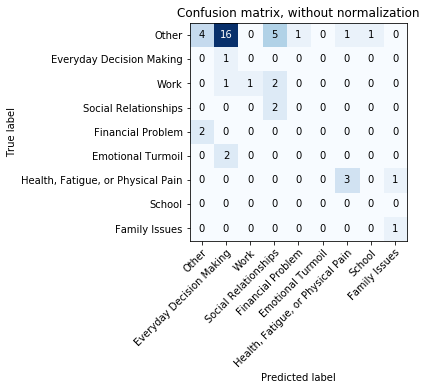

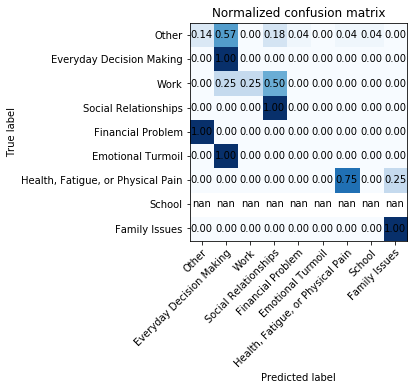

In [225]:
get_confusion_matrix(y_test=test[LABEL_COLUMN],predicted=test_final_labels,labels=label_list_text)

In [232]:
type(test) 

pandas.core.frame.DataFrame

### Exporting test set with probabilities

In [236]:
test, experiment_df = get_test_experiment_df(test)

not much some i'm on vacation
trip to reno
travel
it's been a long day and i'm looking forward to relaxing
just done with a bridge tournament
i think i have trich
i'm hungry
really tired right now
sleep
social stuff
groceries
sex
submitting an email
not too much
i'm not stressed today
?
no
how are you
larissa
nothing really
nothing is stressing me out
no problem
hi
bueller?
nothing!
new day
nothing much
nothing really - just wanted to say hello
sure
what scenario?
i don't have a scenario
i am good
which bot am i talking to?
i'm doing fine
just a regular day
nothing
i'm not stressed right now
and name
nothing! i'm having a good time right now
honestly not much
games
my son
this project that im working on
i'm wasting some of my time
[101, 2025, 2172, 2070, 1045, 1005, 1049, 2006, 10885, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:num_labels:9;logits:Tensor("loss/BiasAdd:0", shap

In [237]:
experiment_df.to_csv(EXPERIMENTS_PATH+'/test_with_probabilities_44_not_stressor.csv') 

In [ ]:
experiment_df

### RUN ALL CELLS ABOVE ON HERE

In [151]:
#experiment_df[experiment_df['Predicted'] != experiment_df['Answer.Label']].head(10) # change head(n) to see more  

KeyError: 'Answer.Label'

# Exporting the model as Pb format

In [41]:
def export_model(dir_path):
    MAX_SEQ_LEN = 128
    def serving_input_receiver_fn():
        """An input receiver that expects a serialized tf.Example."""
        reciever_tensors = {
            "input_ids": tf.placeholder(dtype=tf.int32,
                                        shape=[1, MAX_SEQ_LEN])
        }
        features = {
            "label_ids":tf.placeholder(tf.int32, [None], name='label_ids'),
            "input_ids": reciever_tensors['input_ids'],
            "input_mask": 1 - tf.cast(tf.equal(reciever_tensors['input_ids'], 0), dtype=tf.int32),
            "segment_ids": tf.zeros(dtype=tf.int32,
                                    shape=[1, MAX_SEQ_LEN])
            
        }
        return tf.estimator.export.ServingInputReceiver(features, reciever_tensors)

    estimator._export_to_tpu = False
    estimator.export_saved_model(dir_path, serving_input_receiver_fn)

In [114]:
export_model('./tfmode/pbformat/')

NameError: name 'export_model' is not defined

## Getting analysis for a another dataset

In [117]:
test_all_live = pd.read_csv(PATH+'PopbotsLive_TestSet_213.csv')

test_all_live, experiment_df_live = get_test_experiment_df(test_all_live)

INFO:tensorflow:Writing example 0 of 213


INFO:tensorflow:Writing example 0 of 213


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] big trip home [SEP]


INFO:tensorflow:tokens: [CLS] big trip home [SEP]


INFO:tensorflow:input_ids: 101 2502 4440 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2502 4440 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] com ##mut ##ing to work [SEP]


INFO:tensorflow:tokens: [CLS] com ##mut ##ing to work [SEP]


INFO:tensorflow:input_ids: 101 4012 28120 2075 2000 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4012 28120 2075 2000 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] tires [SEP]


INFO:tensorflow:tokens: [CLS] tires [SEP]


INFO:tensorflow:input_ids: 101 13310 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13310 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 2502, 4440, 2188, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tfmodel_09_04_2020v2/model.ckpt-166


INFO:tensorflow:Restoring parameters from ./tfmodel_09_04_2020v2/model.ckpt-166


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


,Answer.Stressor,Answer.Label,Predicted,Emotional Turmoil,Family Issue,Financial Problem,Health or Physical Pain,School,Work,Other,Everyday Decision Making,Social Relationships
0,Big trip home,Commute,Other,0.272378,0.131272,0.037065,0.024605,0.011082,0.020390,0.424965,0.049417,0.028825
1,Commuting to work,Commute,Work,0.126643,0.009934,0.009344,0.035849,0.007175,0.594073,0.096021,0.088991,0.031971
2,Flat tire,Commute,Work,0.098246,0.038938,0.253883,0.064022,0.018223,0.273120,0.161729,0.074507,0.017333
3,Flat tire,Commute,Work,0.091649,0.036717,0.248963,0.064104,0.017233,0.291003,0.160127,0.070948,0.019256
4,Tires,Commute,Financial Problem,0.099142,0.051423,0.253456,0.037280,0.035590,0.184224,0.247975,0.071764,0.019146
5,traffic!,Commute,Work,0.143932,0.019284,0.084309,0.041000,0.034181,0.392411,0.186211,0.079066,0.019606
6,Travel,Commute,Other,0.287636,0.056697,0.018208,0.028406,0.010985,0.041920,0.480069,0.046924,0.029155
7,2 of my foster kittens died,Emotional Turmoil,Family Issue,0.070396,0.791616,0.016444,0.032129,0.015836,0.004235,0.027521,0.012297,0.029527
8,Feeling insecure about my short hair,Emotional Turmoil,Emotional Turmoil,0.391046,0.204847,0.013058,0.131414,0.020372,0.029646,0.072775,0.058624,0.078217
9,Feeling lonely,Emotional Turmoil,Emotional Turmoil,0.338041,0.327069,0.021340,0.031170,0.010475,0.009327,0.174159,0.035103,0.053316
